In [1]:
from matplotlib import *
from __future__ import division
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp


## homogeneous population, deterministic model

In [16]:
# set the seeding city
seed = 0
nseeds = 10

# Parameters
num_patches = 5 # Number of patches
beta = 0.5     # Infection rate
gamma = 0.2      # Recovery rate
population = 400  # Total population per patch

# Time span for simulation
t_max = 200
t_span = (0, t_max)
t_eval = np.linspace(0, t_max-1, t_max*5)
dt = t_eval[1]-t_eval[0]

subpopulation_R0 = beta/gamma

#upper bound of final attack ratio, asymptotic state assuming R(inf) = N and initial S = N
attack_ratio = population*(1 - np.exp(-subpopulation_R0))
print(subpopulation_R0 , attack_ratio)

2.5 367.16600055044046


### create the matrix of transitions  $\large \sigma_{ij}$

In [17]:
#create random matrix of transitions 
np.random.seed(9001)
#let movements between i!=j must be lower than between i=j
OD_matrix = np.random.random_integers(low=0, high=0.1 * population / num_patches, size=(num_patches,num_patches))
#set diagonal to zero
n = OD_matrix.shape[0]
OD_matrix[range(n), range(n)] = 0 
#flows between i and j must be symmetric, those who go also come back
OD_matrix = (OD_matrix+OD_matrix.T)
#count how many do not move in each population
staying = population - OD_matrix.sum(axis=1)
#set movements in the diagonal i = j
OD_matrix[range(n), range(n)] = staying
#normalize rows to sum to 1, these are rates of transition per population
row_sums = OD_matrix.sum(axis=1, keepdims=True)
# Transition matrix for mobility between patches (Markovian)
P = OD_matrix / row_sums

/var/folders/q5/29y9rnzj2_3f5fwgkltpph4h0000gn/T/ipykernel_47819/614968032.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 8.0 + 1) instead
  OD_matrix = np.random.random_integers(low=0, high=0.1 * population / num_patches, size=(num_patches,num_patches))


In [18]:
staying

array([348, 367, 372, 376, 371])

In [19]:
OD_matrix

array([[348,  13,  15,  15,   9],
       [ 13, 367,   4,   3,  13],
       [ 15,   4, 372,   4,   5],
       [ 15,   3,   4, 376,   2],
       [  9,  13,   5,   2, 371]])

In [20]:
OD_matrix.sum(axis=1, keepdims=True)

array([[400],
       [400],
       [400],
       [400],
       [400]])

In [21]:
P #the sigma_ij matrix of travel rates

array([[0.87  , 0.0325, 0.0375, 0.0375, 0.0225],
       [0.0325, 0.9175, 0.01  , 0.0075, 0.0325],
       [0.0375, 0.01  , 0.93  , 0.01  , 0.0125],
       [0.0375, 0.0075, 0.01  , 0.94  , 0.005 ],
       [0.0225, 0.0325, 0.0125, 0.005 , 0.9275]])

### write the force of infection  
write the force of infection for the reaction process within the patch

$\Large \lambda_i = \beta \ {\frac{I_i}{N_i} }$

In [22]:
# Force of infection function
def force_of_infection(beta, I, P, N):
    return beta * I / N 

### write the ODE system

$\Large \begin{cases}
    \frac{dS_i}{dt} = -\beta \frac{S_iI_i}{N_i} + \langle \Omega_i(S) \rangle \\ 
    \frac{dI_i}{dt} = \beta \frac{S_iI_i}{N_i} - \mu I_i + \langle \Omega_i(S) \rangle \\
\frac{dR_i}{dt} =  \mu I_i  + \langle \Omega_i(S) \rangle 
\end{cases}$

In [23]:

# Initial conditions (S, I, R for each patch)
S0 = np.linspace(population,population, num_patches) # initial susceptible populations
S0[seed] -= nseeds   # remove seeds from seed susceptible populations

I0 = np.zeros(num_patches) # initial infected populations
I0[seed] = nseeds          # seeds
R0 = np.zeros(num_patches) # initial recovered populations


# Model system of ODEs
def sir_model(t, y, beta, gamma, P, population):
    # Reshape the state vector y into S, I, R for each patch
    S = y[:num_patches] #top rows
    I = y[num_patches:2*num_patches] #middle rows
    R = y[2*num_patches:] #bottom rows
    
    # Calculate the force of infection for each patch
    N = np.array([population] * num_patches)
    lambda_i = force_of_infection(beta, I, P, N)
    
    # Compute the derivatives for each patch
    dSdt = - S * lambda_i + np.dot(S, P) - S * np.sum(P, axis=1)
    dIdt = S * lambda_i - gamma * I  + np.dot(I, P) - I * np.sum(P, axis=1)
    dRdt = gamma * I + np.dot(R, P) - R * np.sum(P, axis=1)

    # Concatenate the derivatives into a single vector
    return np.concatenate([dSdt, dIdt, dRdt])

# Initial state vector
y0 = np.concatenate([S0, I0, R0]) #top rows = S, second rows = I, bottom rows = R

# Solve the system of ODEs
solution = solve_ivp(sir_model, t_span, y0, args=(beta, gamma, P, population), t_eval=t_eval)

# Extract results
S, I, R = solution.y[:num_patches], solution.y[num_patches:2*num_patches], solution.y[2*num_patches:]



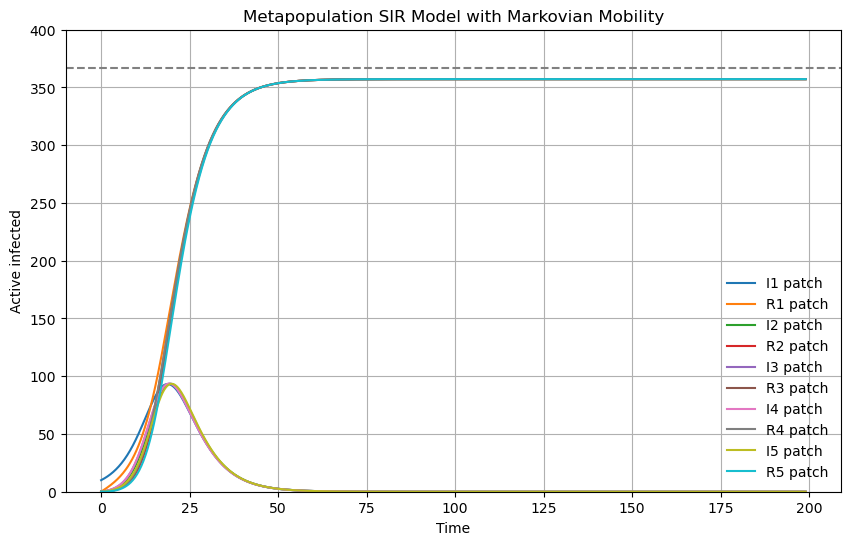

In [24]:
# Plot the results
plt.figure(figsize=(10, 6))

# Plot Susceptible, Infected, and Recovered over time
for i in range(num_patches):
    plt.plot(solution.t, I[i], label=f'I{ i+1 } patch')
    plt.plot(solution.t, R[i], label=f'R{ i+1 } patch')

    #plt.plot(solution.t, S[i]+I[i]+R[i], label=f'R{ i+1 } (Recovered)')

plt.xlabel('Time')
plt.axhline(attack_ratio,ls='--', color='grey')
plt.ylim(0,population)
plt.ylabel('Active infected')
plt.legend(frameon=False)
plt.title('Metapopulation SIR Model with Markovian Mobility')
plt.grid(True)
plt.show()

In [25]:
final_attack_ratio = R[:,-1]/population
print(final_attack_ratio*100, population)

[89.29977916 89.29977944 89.29977912 89.2997787  89.29977955] 400


## heterogeneous populations, deterministic model

In [26]:
population = np.array([400,100,400,1000,400])  # Total population per patch
S0 = np.array(population)

#create random matrix of transitions 
np.random.seed(9001)
#let movements between i!=j must be lower than between i=j
OD_matrix = np.random.random_integers(low=0, high=0.5 * min(population) / num_patches, size=(num_patches,num_patches))
#set diagonal to zero
n = OD_matrix.shape[0]
OD_matrix[range(n), range(n)] = 0 
#flows between i and j must be symmetric, those who go also come back
OD_matrix = (OD_matrix+OD_matrix.T)
#count how many do not move in each population
staying = population - OD_matrix.sum(axis=1)
#set movements in the diagonal i = j
OD_matrix[range(n), range(n)] = staying
#normalize rows to sum to 1, these are rates of transition per population
row_sums = OD_matrix.sum(axis=1, keepdims=True)
# Transition matrix for mobility between patches (Markovian)
P = OD_matrix / row_sums

/var/folders/q5/29y9rnzj2_3f5fwgkltpph4h0000gn/T/ipykernel_47819/3351329585.py:7: DeprecationWarning: This function is deprecated. Please call randint(0, 10.0 + 1) instead
  OD_matrix = np.random.random_integers(low=0, high=0.5 * min(population) / num_patches, size=(num_patches,num_patches))


In [27]:
staying

array([342,  66, 360, 956, 370])

In [28]:
OD_matrix

array([[342,  14,  17,  16,  11],
       [ 14,  66,   6,   9,   5],
       [ 17,   6, 360,  11,   6],
       [ 16,   9,  11, 956,   8],
       [ 11,   5,   6,   8, 370]])

In [29]:
OD_matrix.sum(axis=1, keepdims=True)

array([[ 400],
       [ 100],
       [ 400],
       [1000],
       [ 400]])

In [30]:
P

array([[0.855 , 0.035 , 0.0425, 0.04  , 0.0275],
       [0.14  , 0.66  , 0.06  , 0.09  , 0.05  ],
       [0.0425, 0.015 , 0.9   , 0.0275, 0.015 ],
       [0.016 , 0.009 , 0.011 , 0.956 , 0.008 ],
       [0.0275, 0.0125, 0.015 , 0.02  , 0.925 ]])

In [31]:

subpopulation_R0 = beta/gamma
attack_ratio = population*(1 - np.exp(-subpopulation_R0))
print(subpopulation_R0 , attack_ratio)

# Initial conditions (S, I, R for each patch)
S0 = np.array(population) # initial susceptible populations
S0[seed] -= nseeds   # remove seeds from seed susceptible populations

I0 = np.zeros(num_patches) # initial infected populations
I0[seed] = nseeds          # seeds
R0 = np.zeros(num_patches) # initial recovered populations

# Model system of ODEs
def sir_model(t, y, beta, gamma, P, population):
    # Reshape the state vector y into S, I, R for each patch
    S = y[:num_patches] #top rows
    I = y[num_patches:2*num_patches] #middle rows
    R = y[2*num_patches:] #bottom rows
    
    # Calculate the force of infection for each patch
    lambda_i = force_of_infection(beta, I, P, population)
    
    # Compute the derivatives for each patch
    dSdt = - S * lambda_i + np.dot(S, P) - S * np.sum(P, axis=1)
    dIdt = S * lambda_i - gamma  * I + np.dot(I, P) - I * np.sum(P, axis=1)
    dRdt = gamma * I + np.dot(R, P) - R * np.sum(P, axis=1)
    
    # Concatenate the derivatives into a single vector
    return np.concatenate([dSdt, dIdt, dRdt])

# Initial state vector
y0 = np.concatenate([S0, I0, R0]) #top rows = S, second rows = I, bottom rows = R

# Solve the system of ODEs
solution = solve_ivp(sir_model, t_span, y0, args=(beta, gamma, P, population), t_eval=t_eval)

# Extract results
S, I, R = solution.y[:num_patches], solution.y[num_patches:2*num_patches], solution.y[2*num_patches:]



2.5 [367.16600055  91.79150014 367.16600055 917.91500138 367.16600055]


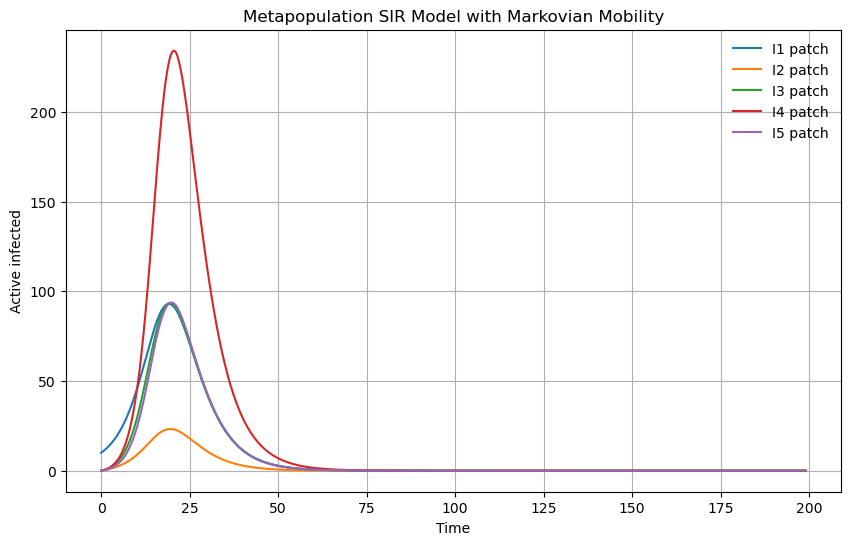

In [32]:
# Plot the results
plt.figure(figsize=(10, 6))

# Plot Susceptible, Infected, and Recovered over time
for i in range(num_patches):
    plt.plot(solution.t, I[i], label=f'I{ i+1 } patch')
    #plt.plot(solution.t, S[i]+I[i]+R[i], label=f'R{ i+1 } (Recovered)')

plt.xlabel('Time')
plt.ylabel('Active infected')
plt.legend(frameon=False)
plt.title('Metapopulation SIR Model with Markovian Mobility')
plt.grid(True)
plt.show()

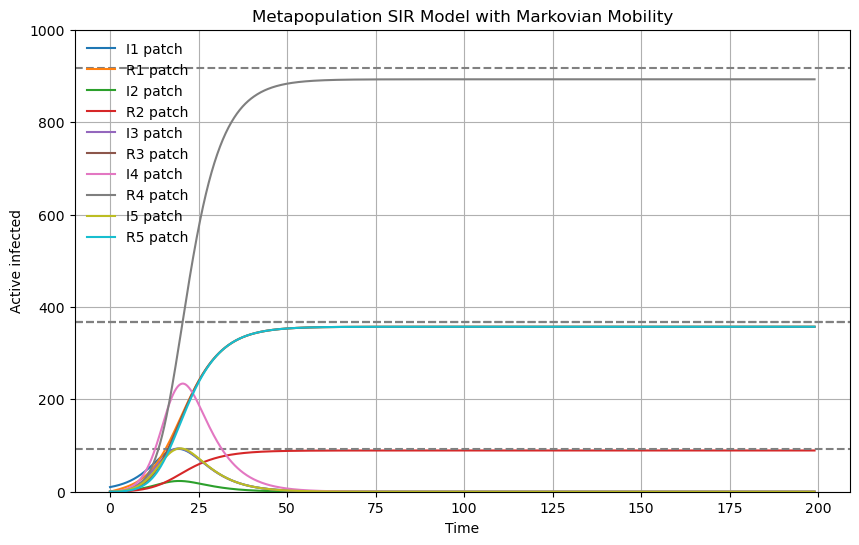

In [33]:
# Plot the results
plt.figure(figsize=(10, 6))

# Plot Susceptible, Infected, and Recovered over time
for i in range(num_patches):
    plt.plot(solution.t, I[i], label=f'I{ i+1 } patch')
    plt.plot(solution.t, R[i], label=f'R{ i+1 } patch')
    plt.axhline(attack_ratio[i],ls='--', color='grey')

    #plt.plot(solution.t, S[i]+I[i]+R[i], label=f'R{ i+1 } (Recovered)')

plt.xlabel('Time')

plt.ylim(0,max(population))
plt.ylabel('Active infected')
plt.legend(frameon=False)
plt.title('Metapopulation SIR Model with Markovian Mobility')
plt.grid(True)
plt.show()

In [34]:
final_attack_ratio = R[:,-1]/population
print(final_attack_ratio*100, population)

[89.27025481 89.2702538  89.27025472 89.27025466 89.27025474] [ 400  100  400 1000  400]


### apply travel bans

In [35]:

ban = 0.5 #value from 0 to 1

OD_matrix_ban = np.zeros((num_patches, num_patches))

for i in range(n):
    for j in range(n):
        if i!=j:
            OD_matrix_ban[i,j] = (1-ban)*OD_matrix[i,j]

#count how many do not move in each population
staying = population - OD_matrix_ban.sum(axis=1)
#set movements in the diagonal i = j
OD_matrix_ban[range(n), range(n)] = staying
            
#normalize rows to sum to 1, these are rates of transition per population
row_sums = OD_matrix_ban.sum(axis=1, keepdims=True)
# Transition matrix for mobility between patches (Markovian)
P = OD_matrix_ban / row_sums

In [36]:
P

array([[0.9275 , 0.0175 , 0.02125, 0.02   , 0.01375],
       [0.07   , 0.83   , 0.03   , 0.045  , 0.025  ],
       [0.02125, 0.0075 , 0.95   , 0.01375, 0.0075 ],
       [0.008  , 0.0045 , 0.0055 , 0.978  , 0.004  ],
       [0.01375, 0.00625, 0.0075 , 0.01   , 0.9625 ]])

In [37]:

subpopulation_R0 = beta/gamma
attack_ratio = population*(1 - np.exp(-subpopulation_R0))
print(subpopulation_R0 , attack_ratio)

# Initial conditions (S, I, R for each patch)
S0 = np.array(population) # initial susceptible populations
S0[seed] -= nseeds   # remove seeds from seed susceptible populations

I0 = np.zeros(num_patches) # initial infected populations
I0[seed] = nseeds          # seeds
R0 = np.zeros(num_patches) # initial recovered populations

# Model system of ODEs
def sir_model(t, y, beta, gamma, P, population):
    # Reshape the state vector y into S, I, R for each patch
    S = y[:num_patches] #top rows
    I = y[num_patches:2*num_patches] #middle rows
    R = y[2*num_patches:] #bottom rows
    
    # Calculate the force of infection for each patch
    lambda_i = force_of_infection(beta, I, P, population)
    
    # Compute the derivatives for each patch
    dSdt = - S * lambda_i + np.dot(S, P) - S * np.sum(P, axis=1)
    dIdt = S * lambda_i - gamma  * I + np.dot(I, P) - I * np.sum(P, axis=1)
    dRdt = gamma * I + np.dot(R, P) - R * np.sum(P, axis=1)
    
    # Concatenate the derivatives into a single vector
    return np.concatenate([dSdt, dIdt, dRdt])

# Initial state vector
y0 = np.concatenate([S0, I0, R0]) #top rows = S, second rows = I, bottom rows = R

# Solve the system of ODEs
solution = solve_ivp(sir_model, t_span, y0, args=(beta, gamma, P, population), t_eval=t_eval)

# Extract results
Sc, Ic, Rc = solution.y[:num_patches], solution.y[num_patches:2*num_patches], solution.y[2*num_patches:]



2.5 [367.16600055  91.79150014 367.16600055 917.91500138 367.16600055]


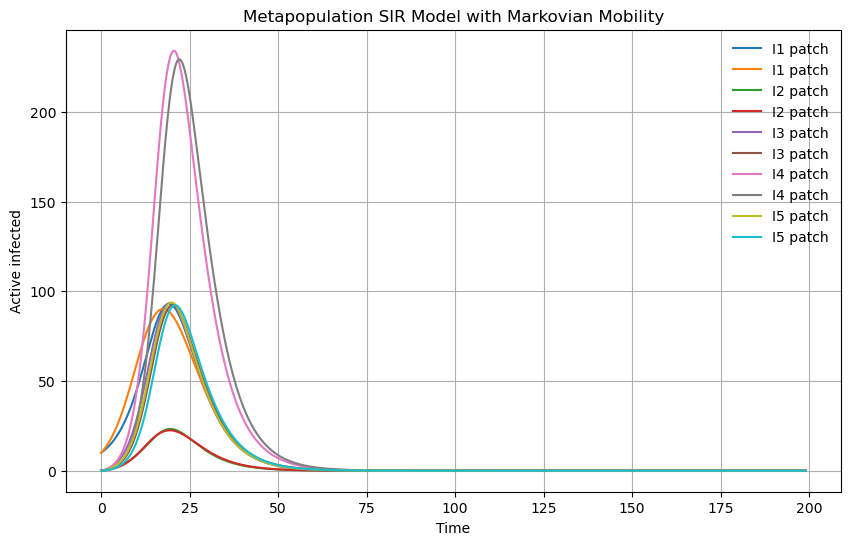

In [38]:
# Plot the results
plt.figure(figsize=(10, 6))

# Plot Susceptible, Infected, and Recovered over time
for i in range(num_patches):
    plt.plot(solution.t, I[i], label=f'I{ i+1 } patch')
    plt.plot(solution.t, Ic[i], label=f'I{ i+1 } patch')

    #plt.plot(solution.t, S[i]+I[i]+R[i], label=f'R{ i+1 } (Recovered)')

plt.xlabel('Time')
plt.ylabel('Active infected')
plt.legend(frameon=False)
plt.title('Metapopulation SIR Model with Markovian Mobility')
plt.grid(True)
plt.show()

tempo guadagnato grazie alle restrizioni

In [39]:
for i in range(num_patches):
    print('Population #'+str(i), round(solution.t[np.argmax(Ic[i])]-solution.t[np.argmax(I[i])]), 'days')

Population #0 -2 days
Population #1 0 days
Population #2 1 days
Population #3 2 days
Population #4 1 days


#### verify what happens with  R0 < 1  
#### verify delay of epidemics when banning 80 - 99% of trips